# Review tweets in database
pull tweets out of a database by their timing information. Example dataset: #Sowoozoo during replay of D1

To use this notebook, make sure you have python installed (I recommend using anaconda to get set up quickly), then download this notebook, the twt.py file, and the folder named data shared by drive, and make sure they are all in the folder on your computer (files Check_Twts... twt.py and folder /data/)

Note: the Fan_tweets_H_Sowoozoo_R1.csv file containes all tweets with the hashtag #sowoozoo as caught in the 3.5 hours around the live streamed concert EXCLUDING tweets and retweets of tweets by official accounts @BTS_TWT and @bighit_bts. The results is a database of tweets primarily by fans who are concurrently watching the performance live stream. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
# import twt functions from twt.py file
%reload_ext autoreload
%autoreload 1
%aimport twt

In [3]:
# retrieve the fan tweets from during the concert R1 and the timing information for the events
data_name = 'SWZ_R1'

# go into the data folder
os.chdir('./data') 
# convert the csv file into a pandas database
df_alltwt=pd.read_csv('Fan_tweets_H_Sowoozoo_R1.csv')
# make sure the time values are machine readable
df_alltwt["created_at"] = pd.to_datetime(df_alltwt["created_at"]) 
# load the timing of D1 concert
concert_times=pd.read_csv('Setlists_sowoozoo_D1.csv') 
# correct the timing of concert events by adding the time between original performance and replay
    # added 6 minutes to account for delays in start time, so songs begin less than a minute before the first yell tweet of recognition
replay_shift = pd.to_datetime('2021-06-19 00:30:00+0000') - pd.to_datetime('2021-06-13 9:00:00+0000')
concert_times["starttime"] = pd.to_datetime(concert_times["starttime"]) + pd.Timedelta(minutes=5.5) + replay_shift
concert_times=concert_times.set_index("starttime", drop=True)

os.chdir('..') # return to the main folder

In [4]:
concert_times
# all concert times are in UTC time

,order,event
starttime,,
2021-06-19 01:00:30+00:00,0,Pre-stream
2021-06-19 01:05:30+00:00,1,tinytans open
2021-06-19 01:06:55+00:00,2,VCR1 - wake up
2021-06-19 01:09:42+00:00,3,Life goes on
2021-06-19 01:13:00+00:00,4,Butter
2021-06-19 01:15:49+00:00,5,Dynamite--Tropical
2021-06-19 01:19:05+00:00,6,Live 1
2021-06-19 01:26:25+00:00,7,ARMY signals
2021-06-19 01:34:22+00:00,8,Moving On


In [5]:
print('Size of full set: ' + str(len(df_alltwt)))
twts = df_alltwt['tweet'] 
df_fantwt = df_alltwt.loc[~(twts.str.contains('T @weverseofficial:', case=False,regex=False)
                            |twts.str.contains('T @HYBE_MERCH:', case=False,regex=False)
                            |twts.str.contains('T @bts_bighit:', case=False,regex=False)
                            |twts.str.contains('T @BTS_twt:', case=False,regex=False))] # 
print('Size of cleaned set: ' + str(len(df_fantwt)))

Size of full set: 18706
Size of cleaned set: 13163


In [6]:
# time range of database imported (UTC 0)
time_start = df_alltwt['created_at'].min()
time_end = df_alltwt['created_at'].max()
print([time_start,time_end])

# reorder tweets to be in chronological order (convenient for computation to follow)
df_alltwt_ord = df_alltwt.sort_values('created_at')
df_alltwt_ord = df_alltwt_ord.reset_index(drop=True)

[Timestamp('2021-06-19 00:30:02+0000', tz='UTC'), Timestamp('2021-06-19 03:59:57+0000', tz='UTC')]


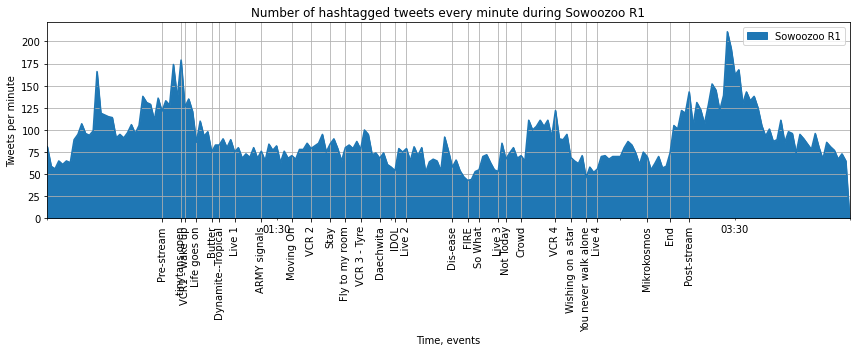

In [7]:
# plot the nubmer of tweets posted a minute!

# concert started airing at 9:30 UTC (18:30 KST, UTC +9) ['2021-06-13 9:30:00+0000','2021-06-13 11:45:00+0000'] 
minutely_dt = pd.date_range(pd.to_datetime('2021-06-19 00:30:00+0000'), pd.to_datetime('2021-06-19 04:00:00+0000'), freq='1Min')
df_mn_counts = pd.DataFrame(index = minutely_dt)
df_counted = twt.ind_set_counts(df_alltwt_ord,'created_at',minutely_dt)
df_mn_counts['Sowoozoo R1'] = df_counted['Counts'].values

df_mn_counts.plot.area(figsize=(12,5))
plt.title('Number of hashtagged tweets every minute during Sowoozoo R1')
plt.xlabel('Time, events')
plt.ylabel('Tweets per minute')

plt.xticks(concert_times.index,concert_times.event, rotation='vertical')
plt.grid()
plt.tight_layout()
#plt.savefig('ALL_Fans_Tweet_rate_'+ data_name + '.png',dpi = 300)
plt.show()

Now seperate out different categories of tweets and report some descriptive statistics

In [8]:
set_size = len(df_alltwt_ord)
print('Full set: ' + str(set_size) + ' tweets by ' +  str(len(df_alltwt_ord['user_id'].unique())) + ' users' )

# original tweets, replys, amplification tweets
df_replys = df_alltwt_ord.loc[df_alltwt_ord['in_reply_to_user_id'].notna(),:].reset_index()
print('Number of reply tweets in set: ' + str(len(df_replys))  + ' (' + str(len(df_replys)/set_size) + ')')
print('    Replying to ' + str(len(df_replys['in_reply_to_user_id'].unique())) + ' tweets')

df_RT = df_alltwt_ord.loc[df_alltwt_ord['retweeted_status_id'].notna(),:].reset_index()
print('Number of retweeting tweets in set: ' + str(len(df_RT))  + ' (' + str(len(df_RT)/set_size) + ')')
print('    Retweeting ' + str(len(df_RT['retweeted_status_id'].unique())) + ' tweets')

df_QT = df_alltwt_ord.loc[df_alltwt_ord['quoted_status_id'].notna(),:].reset_index()
print('Number of quote tweeting tweets in set: ' + str(len(df_QT)) + ' (' + str(len(df_QT)/set_size) + ')')
print('    Quoting ' + str(len(df_QT["quoted_status_id"].unique())) + ' tweets')

df_Ori = df_alltwt_ord.loc[df_alltwt_ord['retweeted_status_id'].isna(),:]
df_Ori = df_Ori.loc[df_Ori['quoted_status_id'].isna(),:] 
df_Ori = df_Ori.loc[df_Ori['in_reply_to_status_id'].isna(),:].reset_index()                    
print('Number of Original tweets in set: ' + str(len(df_Ori)) + ' (' + str(len(df_Ori)/set_size) + ')')
print('    with ' + str(len(df_Ori["tweet"].unique())) + ' unique messages by ' +  str(len(df_Ori["user_id"].unique())) + ' users')


Full set: 18706 tweets by 11396 users
Number of reply tweets in set: 155 (0.008286111408104351)
    Replying to 84 tweets
Number of retweeting tweets in set: 14850 (0.7938629316796749)
    Retweeting 1112 tweets
Number of quote tweeting tweets in set: 928 (0.049609750882069925)
    Quoting 172 tweets
Number of Original tweets in set: 3249 (0.17368758687052283)
    with 3239 unique messages by 1914 users


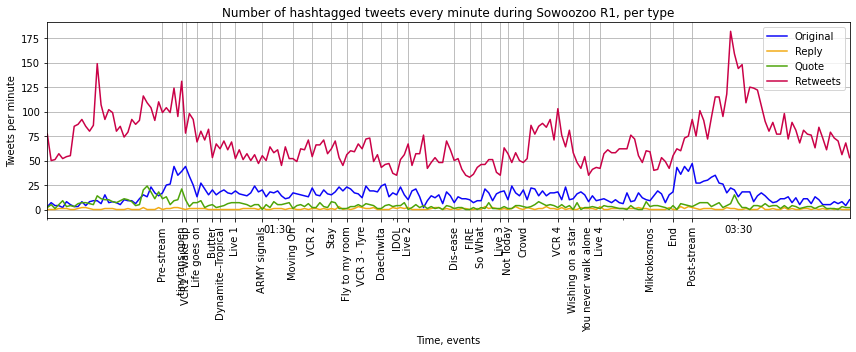

In [9]:
# capture the minute wise rate of each tweet category 
df_mn_counts = pd.DataFrame(index = minutely_dt)
df_counted = twt.ind_set_counts(df_Ori,'created_at',minutely_dt)
df_mn_counts['Original'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_replys,'created_at',minutely_dt)
df_mn_counts['Reply'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_QT,'created_at',minutely_dt)
df_mn_counts['Quote'] = df_counted['Counts'].values
df_counted = twt.ind_set_counts(df_RT,'created_at',minutely_dt)
df_mn_counts['Retweets'] = df_counted['Counts'].values

df_mn_counts=df_mn_counts.drop(index=[df_mn_counts.iloc[-1].name])

cmap1 = ListedColormap(["xkcd:strong blue", "xkcd:squash", "xkcd:lawn green", "xkcd:ruby"])

df_mn_counts.plot.line(figsize=(12,5),cmap=cmap1)
plt.title('Number of hashtagged tweets every minute during Sowoozoo R1, per type')
plt.xlabel('Time, events')
plt.ylabel('Tweets per minute')

plt.xticks(concert_times.index,concert_times.event, rotation='vertical')#, concert_times['event'])
plt.grid()
plt.tight_layout()
#plt.savefig('ALL_Fans_Tweet_Types_rate_'+ data_name + '.png',dpi = 300)
plt.show()

## Sampling tweets
The section that follows pulls tweets from the database in a few configurations 

In [16]:
# checking for alignment of original tweent time stamps and concert events
event_n = 17
a = twt.ind_set(df_Ori,'created_at',concert_times.index[event_n],concert_times.index[event_n+1])

print(concert_times.iloc[event_n,:])
print(concert_times.index[event_n+1].tz_localize(None)-concert_times.index[event_n].tz_localize(None))
print('Number of tweets in this interval: ' + str(len(a)) + '\n')

#print each tweet in interval of time for event listed
for i, row in a.iterrows():
    print(str(i) + ', ' + str(row['created_at']) +': ')
    print(twt.citation(row)+'\n')
#a.iloc[:10,:]

order      17
event    FIRE
Name: 2021-06-19 02:20:17+00:00, dtype: object
0 days 00:03:21
Number of tweets in this interval: 29

1706, 2021-06-19 02:20:17+00:00: 
みぴょん [@mipyon_suga]. (2021, 06 19). シングルビューでも1度目と2度目で気付くところが全然違うから、マルチビューやったらもっとたくさんのことに気付くんだろうなぁ(*´꒳`*) ぜひマルチビューバージョンでDVD化して欲しい☺️📀  #SOWOOZOO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074325875126277

1707, 2021-06-19 02:20:18+00:00: 
•TRD• [@TRDJDK1]. (2021, 06 19). พี่จิน💜🤏🏻 #SOWOOZOO https://t.co/baaOmV5XBO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074329415053317

1708, 2021-06-19 02:20:19+00:00: 
- Aisys⁷ 🧈 ★ 0613-0709 [@icedxlattae]. (2021, 06 19). SICK AND TIIIIIRED 🗣 #SOWOOZOO https://t.co/d8TkSIkwur[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074335585001474

1709, 2021-06-19 02:20:21+00:00: 
Amy⁷∞🧈 [@dastardlypale]. (2021, 06 19). Dis-ease is too good 🙌 #SOWOOZOO[Tweet]. Twitter. https://twitter.com/anyuser/status/1406074343793246212

1710, 2021-06-19 02:20:31+00:00: 
＊あみ＊ [

In [18]:
# print first 10 retweets tweets in defined interval
start_t = '2021-06-19 02:20:17+00:00'
end_t = '2021-06-19 02:21:17+00:00'
a = twt.ind_set(df_RT,'created_at',start_t,end_t)

print('start time: ' + start_t)
print('end time: ' + end_t)
print('Number of retweet tweets in this interval: ' + str(len(a)) + '\n')
print('first 10 retweets:')
#print each tweet in interval of time for event listed
for i, row in a[:10].iterrows():
    print(str(i) + ', ' + str(row['created_at']) +': ')
    print(twt.twt_dets(row)+'\n')

start time: 2021-06-19 02:20:17+00:00
end time: 2021-06-19 02:21:17+00:00
Number of retweet tweets in this interval: 31

first 10 retweets:
7577, 2021-06-19 02:20:17+00:00: 
Mafe Riveros | DUQUE ES UN HPTA🇨🇴. [@MafeRiveros5],2021-06-19 02:20:17+00:00:
https://twitter.com/anyuser/status/1406074324876935172
RT @weverseofficial: BTS 2021 MUSTER SOWOOZOO Delayed Single-view Streaming begins at 10 AM (KST) today!

If you bought the streaming ticket of June 13 concert, visit the link below and get ready!
👉https://t.co/HAetAivDxl

#BTS #SOWOOZOO https://t.co/AJyHuTtvby
RTs: 3018
Likes: 8437


7578, 2021-06-19 02:20:19+00:00: 
ly._xmoarmyen-「💜」𝕓𝕠𝕣𝕒𝕙𝕒𝕖 。 [@ly_xsomeday],2021-06-19 02:20:19+00:00:
https://twitter.com/anyuser/status/1406074333315801094
RT @AnongnapatW: สภาพคนดูรีรันเช้านี้ อย่าหาจัดอะไรเช้าๆอีกนะ บฮ. มี่ขอละ 😂 #SOWOOZOO https://t.co/Z87SRdjUb3
RTs: 284
Likes: 237


7579, 2021-06-19 02:20:25+00:00: 
Anel 🇲🇽 [@AnelRui98280842],2021-06-19 02:20:25+00:00:
https://twitter.com/anyuser/s